In [1]:
import pandas as pd

# Load your real dataset
df = pd.read_csv('../data/processed/full_similarity_with_returns.csv')

# Preview the data
print(df.head())

df = df.rename(columns={"filing_date": "month"})
df = df.rename(columns={"similarity": "similarity_score"})


df


    cik  tic       month  similarity      ret
0  1750  air  1994-01-31         NaN  14.6207
1  1750  air  1994-04-30    0.991912      NaN
2  1750  air  1994-08-31    0.934598  -2.7027
3  1750  air  1994-10-31    0.928699  -4.8462
4  1750  air  1995-01-31    0.868299   1.8318


,cik,tic,month,similarity_score,ret
0,1750,air,1994-01-31,NaN,14.6207
1,1750,air,1994-04-30,0.991912,NaN
2,1750,air,1994-08-31,0.934598,-2.7027
3,1750,air,1994-10-31,0.928699,-4.8462
4,1750,air,1995-01-31,0.868299,1.8318
...,...,...,...,...,...
1303798,2029303,NaN,2024-11-30,NaN,NaN
1303799,2031561,NaN,2024-11-30,NaN,NaN
1303800,2032950,NaN,2024-12-31,NaN,NaN
1303801,2033615,NaN,2024-12-31,NaN,NaN


### Removing missing values

It is valid to drop missing rows. Need description.

In [2]:
print(df.isna().sum())
print(df.shape)

df = df.dropna(subset=['similarity_score'])
df = df.dropna(subset=['tic'])
df = df.dropna(subset=['ret'])

print(df.isna().sum())
print(df.shape)

df

cik                       0
tic                  956934
month                     0
similarity_score    1004951
ret                 1152829
dtype: int64
(1303803, 5)
cik                 0
tic                 0
month               0
similarity_score    0
ret                 0
dtype: int64
(34027, 5)


,cik,tic,month,similarity_score,ret
2,1750,air,1994-08-31,0.934598,-2.7027
3,1750,air,1994-10-31,0.928699,-4.8462
4,1750,air,1995-01-31,0.868299,1.8318
6,1800,abt,1994-05-31,0.934639,5.2863
7,1800,abt,1994-08-31,0.888515,6.6667
...,...,...,...,...,...
1299053,85535,rgld,2024-12-31,0.923907,-9.8523
1300115,1058811,immr,2024-12-31,0.985401,-2.3490
1300909,1393612,dfs,2024-12-31,0.977140,-5.0430
1300910,1393612,dfs,2024-12-31,0.998017,-5.0430


We also need to remove rows where there is only one row per month, since we can't construct that portfolio.

In [3]:
# Step 1: Remove months with only 1 stock
month_counts = df['month'].value_counts()
valid_months = month_counts[month_counts > 1].index
df = df[df['month'].isin(valid_months)].copy()

Assigning quintiles

In [4]:
def custom_assign_quintile(group):
    group = group.sort_values('similarity_score', ascending=False).reset_index(drop=True)
    
    if len(group) == 2:
        group['quintile'] = [5, 1]  # Long top, short bottom
    else:
        group['quintile'] = pd.qcut(group.index, 5, labels=[5,4,3,2,1]).astype(int) # binning handled automatically
    
    return group

df = df.groupby('month', group_keys=False).apply(custom_assign_quintile)

# 5 is long, 1 is short

/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_32795/1733838785.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('month', group_keys=False).apply(custom_assign_quintile)


In [5]:
#Compute monthly long-short portfolio returns
portfolio_rets = []
for month, group in df.groupby('month'):
    long_ret = group.loc[group['quintile'] == 5, 'ret'].mean()
    short_ret = group.loc[group['quintile'] == 1, 'ret'].mean()
    long_short = long_ret - short_ret
    portfolio_rets.append({'month': month, 'portfolio_return': long_short})

portfolio_df = pd.DataFrame(portfolio_rets)
portfolio_df['month'] = pd.to_datetime(portfolio_df['month'])
portfolio_df = portfolio_df.sort_values('month')

In [6]:
#Calculate cumulative return (growth of $1, if ret is percent, convert to decimal first)
portfolio_df['portfolio_return_decimal'] = portfolio_df['portfolio_return'] / 100
portfolio_df['cum_portfolio'] = (1 + portfolio_df['portfolio_return_decimal']).cumprod()


In [7]:
portfolio_df

,month,portfolio_return,portfolio_return_decimal,cum_portfolio
0,1994-01-31,16.980800,0.169808,1.169808
1,1994-02-28,-36.893950,-0.368940,0.738220
2,1994-03-31,-6.443933,-0.064439,0.690649
3,1994-05-31,-0.289555,-0.002896,0.688649
4,1994-06-30,2.171164,0.021712,0.703601
...,...,...,...,...
257,2024-05-31,-3.526745,-0.035267,0.349500
258,2024-07-31,-3.090647,-0.030906,0.338698
259,2024-09-30,-2.230082,-0.022301,0.331145
260,2024-10-31,-1.012677,-0.010127,0.327791


In [8]:
#Output your results
print(portfolio_df.head())
# Save your portfolio DataFrame as a CSV file in the right path
portfolio_df.to_csv("../data/processed/full_portfolio_returns.csv", index=False)


       month  portfolio_return  portfolio_return_decimal  cum_portfolio
0 1994-01-31         16.980800                  0.169808       1.169808
1 1994-02-28        -36.893950                 -0.368940       0.738220
2 1994-03-31         -6.443933                 -0.064439       0.690649
3 1994-05-31         -0.289555                 -0.002896       0.688649
4 1994-06-30          2.171164                  0.021712       0.703601


Plot monthly portfolio returns:

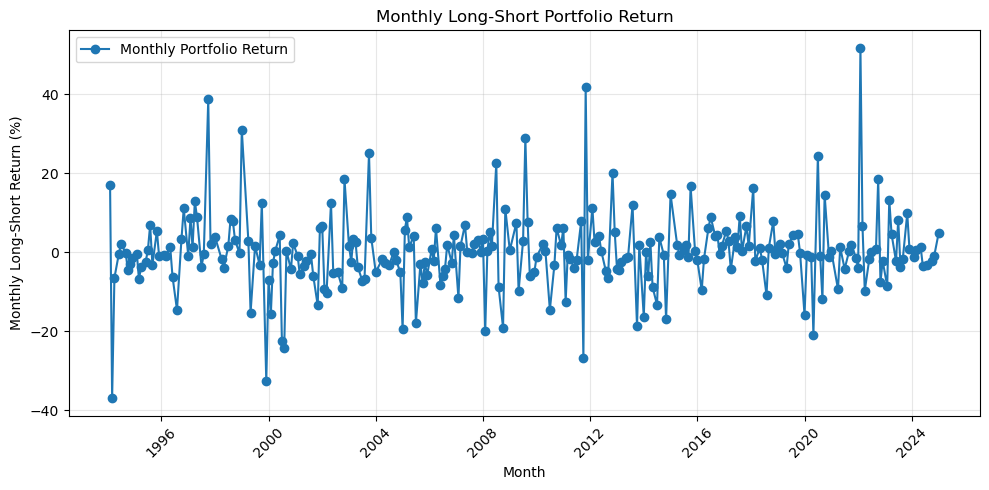

In [9]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['portfolio_return'], marker='o', label='Monthly Portfolio Return')
plt.xlabel('Month')
plt.ylabel('Monthly Long-Short Return (%)')
plt.title('Monthly Long-Short Portfolio Return')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
print(portfolio_df['portfolio_return_decimal'].mean())

portfolio_df

0.0005445054498421094


The monthly returns are extremely volatile.
- trading only 1 long 1 short stock can skew this a lot
- we don't have information on market cap to weigh it


-> might have to only keep portfolios in months with a lot of stocks


Plot cumulative returns

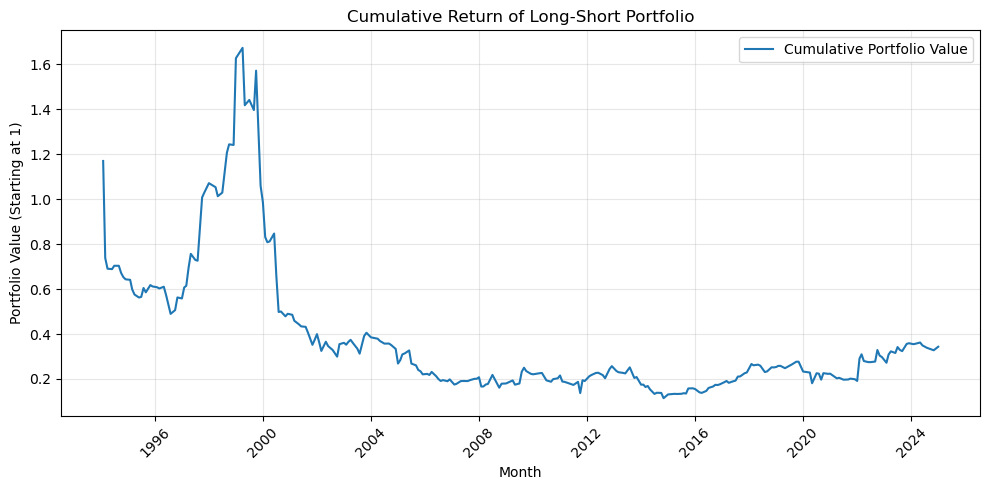

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['cum_portfolio'], label='Cumulative Portfolio Value')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Return of Long-Short Portfolio')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This is a losing strategy. Filter data based on month bin sizes:

In [11]:
# For each month, count how many stocks we have
month_sizes = df['month'].value_counts().sort_index()
print(month_sizes)


month
1994-01-31      2
1994-02-28      8
1994-03-31     28
1994-05-31    310
1994-06-30     67
             ... 
2024-05-31    837
2024-07-31     26
2024-09-30    116
2024-10-31    583
2024-12-31      5
Name: count, Length: 262, dtype: int64


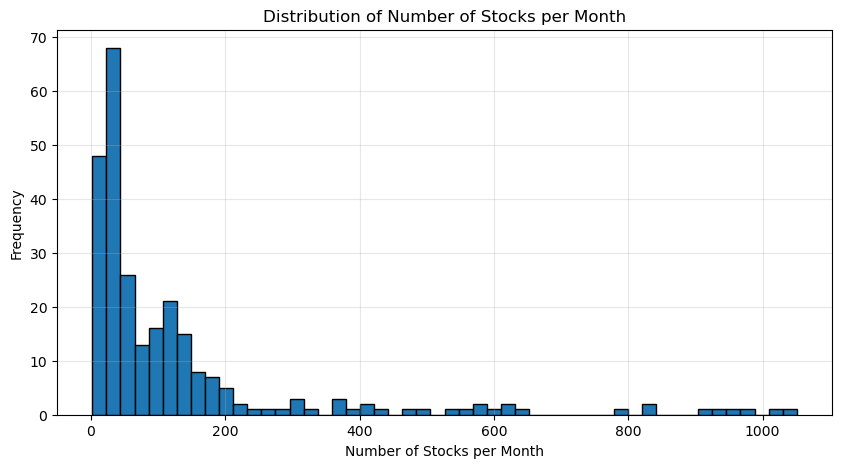

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(month_sizes, bins=50, edgecolor='k')
plt.xlabel('Number of Stocks per Month')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Stocks per Month')
plt.grid(alpha=0.3)
plt.show()


Extremely right-skewed distribution of number of stocks in a month. Let's pick a cutoff value and re-do the analysis:

/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_32795/4230374073.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('month', group_keys=False).apply(custom_assign_quintile)


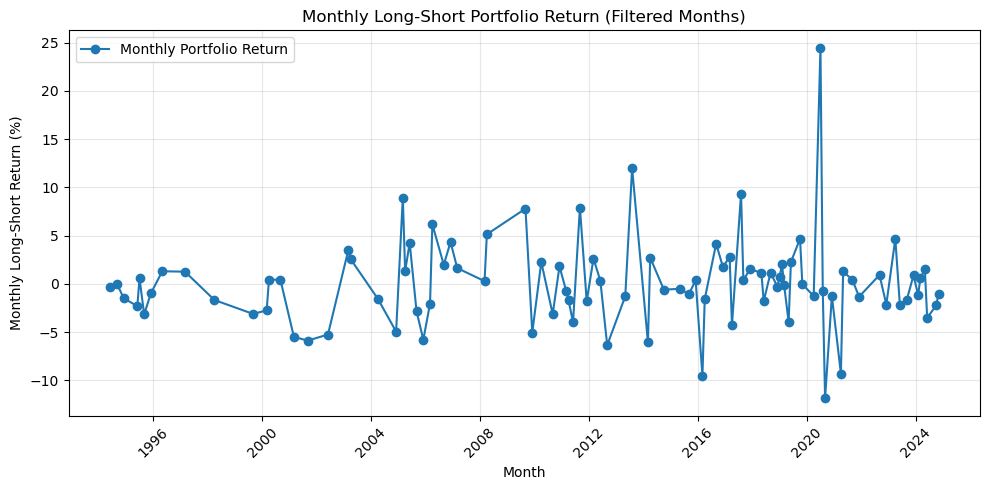

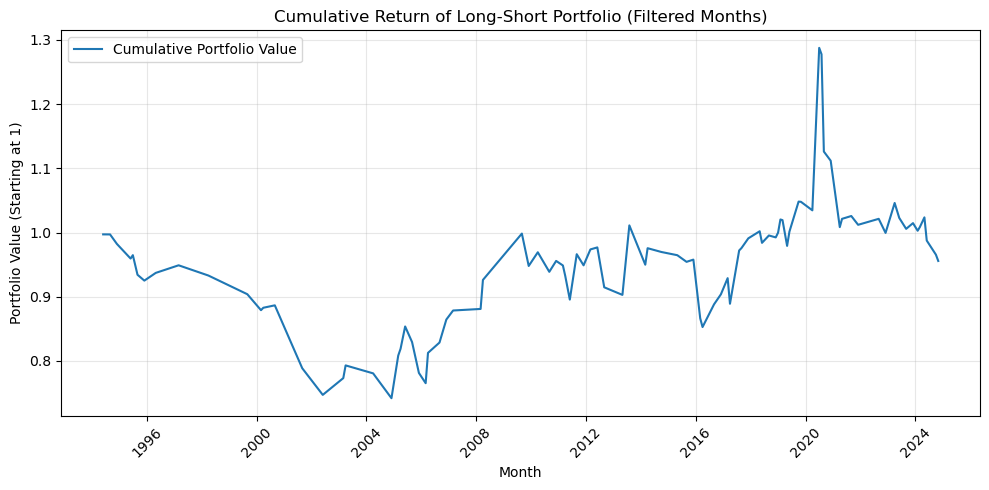

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('../data/processed/full_similarity_with_returns.csv')

# Rename columns for consistency
df = df.rename(columns={"filing_date": "month", "similarity": "similarity_score"})

# Drop missing values
df = df.dropna(subset=['similarity_score', 'tic', 'ret'])

min_months = 100

# Step 1: Remove months with only a few stocks
month_sizes = df['month'].value_counts()
valid_months = month_sizes[month_sizes >= min_months].index  # <-- Keep months with >= 30 stocks
df = df[df['month'].isin(valid_months)].copy()

# Step 2: Assign quintiles manually
def custom_assign_quintile(group):
    group = group.sort_values('similarity_score', ascending=False).reset_index(drop=True)
    
    if len(group) == 2:
        group['quintile'] = [5, 1]  # Long top, short bottom
    else:
        group['quintile'] = pd.qcut(group.index, 5, labels=[5,4,3,2,1]).astype(int)
    
    return group

df = df.groupby('month', group_keys=False).apply(custom_assign_quintile)

# Step 3: Compute monthly long-short portfolio returns
portfolio_rets = []
for month, group in df.groupby('month'):
    long_ret = group.loc[group['quintile'] == 5, 'ret'].mean()
    short_ret = group.loc[group['quintile'] == 1, 'ret'].mean()
    long_short = long_ret - short_ret
    portfolio_rets.append({'month': month, 'portfolio_return': long_short})

portfolio_df = pd.DataFrame(portfolio_rets)
portfolio_df['month'] = pd.to_datetime(portfolio_df['month'])
portfolio_df = portfolio_df.sort_values('month')

# Step 4: Calculate cumulative returns
portfolio_df['portfolio_return_decimal'] = portfolio_df['portfolio_return'] / 100
portfolio_df['cum_portfolio'] = (1 + portfolio_df['portfolio_return_decimal']).cumprod()

# Step 5: Save your results
portfolio_df.to_csv("../data/processed/full_portfolio_returns_filtered.csv", index=False)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['portfolio_return'], marker='o', label='Monthly Portfolio Return')
plt.xlabel('Month')
plt.ylabel('Monthly Long-Short Return (%)')
plt.title('Monthly Long-Short Portfolio Return (Filtered Months)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Step 6: Plot cumulative return
plt.figure(figsize=(10,5))
plt.plot(portfolio_df['month'], portfolio_df['cum_portfolio'], label='Cumulative Portfolio Value')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Return of Long-Short Portfolio (Filtered Months)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
portfolio_df

Getting S&P500 monthly data

In [14]:
sp500 = pd.read_csv("../data/processed/sp500_monthly.csv")

sp500

,month,return
0,NaN,NaN
1,1993-04-01,-0.025417
2,1993-05-01,0.022717
3,1993-06-01,0.000755
4,1993-07-01,-0.005327
...,...,...
381,2024-12-01,-0.024990
382,2025-01-01,0.027016
383,2025-02-01,-0.014242
384,2025-03-01,-0.057545


Plotting S&P500 cumulative returns

/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_32795/841994557.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['month'] = pd.to_datetime(sp500['month'])
/var/folders/nx/v58k3cwd0wlgff1pwy874p600000gn/T/ipykernel_32795/841994557.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['cum_return'] = (1 + sp500['return']).cumprod()


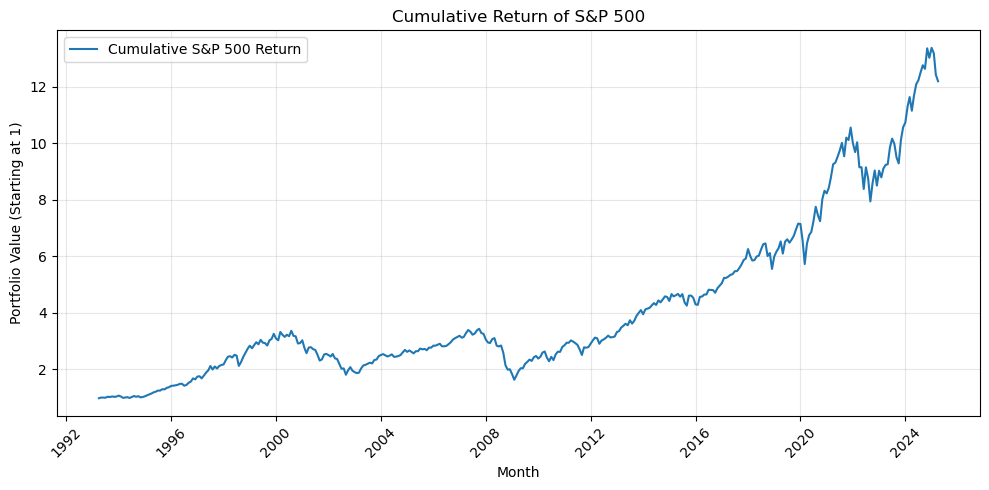

In [15]:
import matplotlib.pyplot as plt

# Drop any rows with missing values (just to be safe)
sp500 = sp500.dropna()

# Convert 'month' column to datetime if it isn't already
sp500['month'] = pd.to_datetime(sp500['month'])

# Calculate cumulative return
sp500['cum_return'] = (1 + sp500['return']).cumprod()

# Plot
plt.figure(figsize=(10,5))
plt.plot(sp500['month'], sp500['cum_return'], label='Cumulative S&P 500 Return')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Return of S&P 500')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


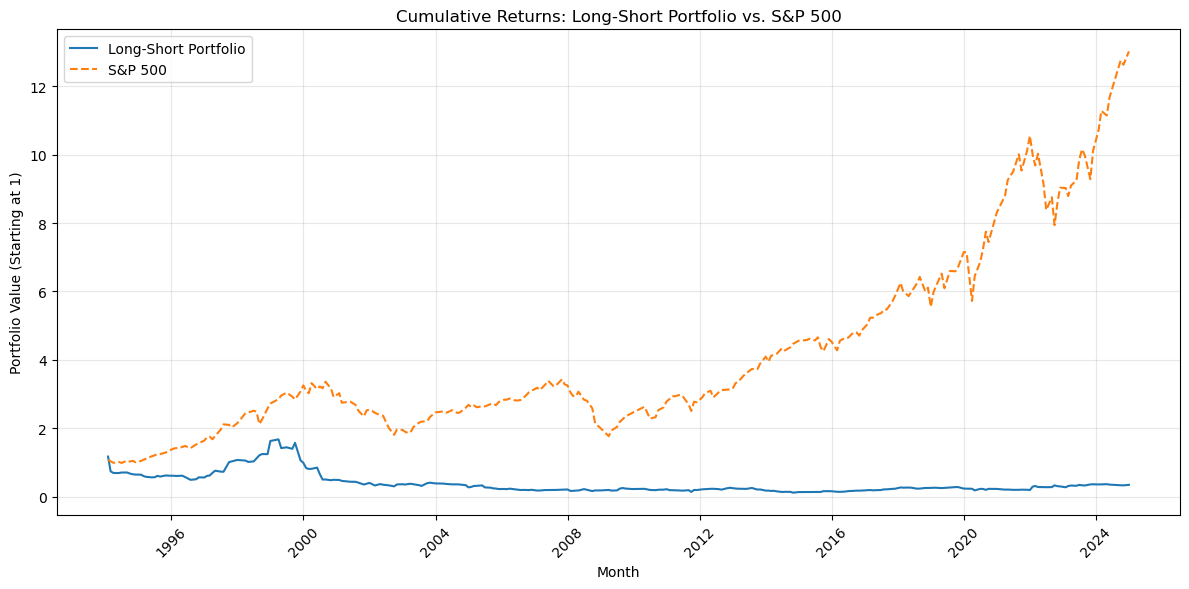

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your portfolio and S&P 500
portfolio_df = pd.read_csv("../data/processed/full_portfolio_returns_filtered.csv")
sp500 = pd.read_csv("../data/processed/sp500_monthly.csv")

# Parse dates
portfolio_df['month'] = pd.to_datetime(portfolio_df['month'])
sp500['month'] = pd.to_datetime(sp500['month'])

# Shift S&P 500 month to end of month
sp500['month'] = sp500['month'] + pd.offsets.MonthEnd(0)

# Calculate cumulative return
sp500['cum_return'] = (1 + sp500['return']).cumprod()

# Merge datasets on month
combined = pd.merge(portfolio_df[['month', 'cum_portfolio']], 
                    sp500[['month', 'cum_return']], 
                    on='month', 
                    how='inner')  # match after shifting

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(combined['month'], combined['cum_portfolio'], label='Long-Short Portfolio')
plt.plot(combined['month'], combined['cum_return'], label='S&P 500', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Portfolio Value (Starting at 1)')
plt.title('Cumulative Returns: Long-Short Portfolio vs. S&P 500')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
sp500

Logic
1.
a. Sort all firms by their similarity_score for that month (the higher the score, the more “similar” their filing is to the previous one).
b. Assign quintiles (divide into 5 groups) based on the similarity_score within that month:
Top 20% (5th quintile): Firms with the highest similarity
Bottom 20% (1st quintile): Firms with the lowest similarity
2.
Long leg: Go long (buy) all stocks in the top quintile (highest similarity).
Short leg: Go short (sell) all stocks in the bottom quintile (lowest similarity).

Returns are equally weighted within each leg (i.e., average the returns for the long group and the short group).
3.
Long-short return = Mean(return of long leg) - Mean(return of short leg)

Key
If the long-short return is consistently positive:It means firms with high similarity (i.e., "lazy" prices) tend to outperform those with low similarity, after controlling for general market movements.


### But let's see if the long-short return is ever "consistently positive"

In [33]:
import numpy as np

# Load your portfolio returns if not already loaded
# portfolio_df = pd.read_csv('../data/processed/full_portfolio_returns_filtered.csv')

# 1. Calculate average monthly long-short return
mean_return = portfolio_df['portfolio_return_decimal'].mean()

# 2. Calculate standard deviation of monthly returns
std_dev = portfolio_df['portfolio_return_decimal'].std()

# 3. Calculate Sharpe ratio (annualized)
sharpe_ratio = (mean_return / std_dev) * np.sqrt(12)  # 12 months per year

# 4. Print results
print(f"Average Monthly Return: {mean_return*100:.4f}%")
print(f"Monthly Return Std Dev: {std_dev*100:.4f}%")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")


Average Monthly Return: 0.0545%
Monthly Return Std Dev: 4.6337%
Annualized Sharpe Ratio: 0.0407


### **Data Quality and Initial Filtering**

When we received the CRSP stock returns data, it was already pre-filtered to include only standard common stocks listed on major U.S. exchanges. Specifically, the dataset was restricted to securities with **shrcd** codes in **(10, 11, 12)** (indicating common shares) and **exchcd** codes in **(1, 2, 3)** (corresponding to NYSE, AMEX, and NASDAQ exchanges, respectively).

This filtering step ensured that we excluded:
- Non-common stock securities (e.g., preferred shares, warrants, ADRs)
- OTC, Pink Sheets, and other non-major exchanges

Thus, our stock universe was already of relatively high quality, focusing on tradable common stocks from major markets.

However, even with this filtering, our universe still contained:
- Very small and illiquid firms
- Firms with extremely volatile returns
- Companies that were formally listed but not actively traded

This explains why, despite starting with cleaner data, the volatility of monthly long-short portfolio returns remains high, and the average returns based on the similarity score signal remain weak across the broad universe.

Ultimately, our low Sharpe ratio is not a result of bad data. Instead, it reflects the fact that the **similarity score signal alone** is **not strong enough to consistently outperform the noise** in stock returns over a long sample period covering many firms.